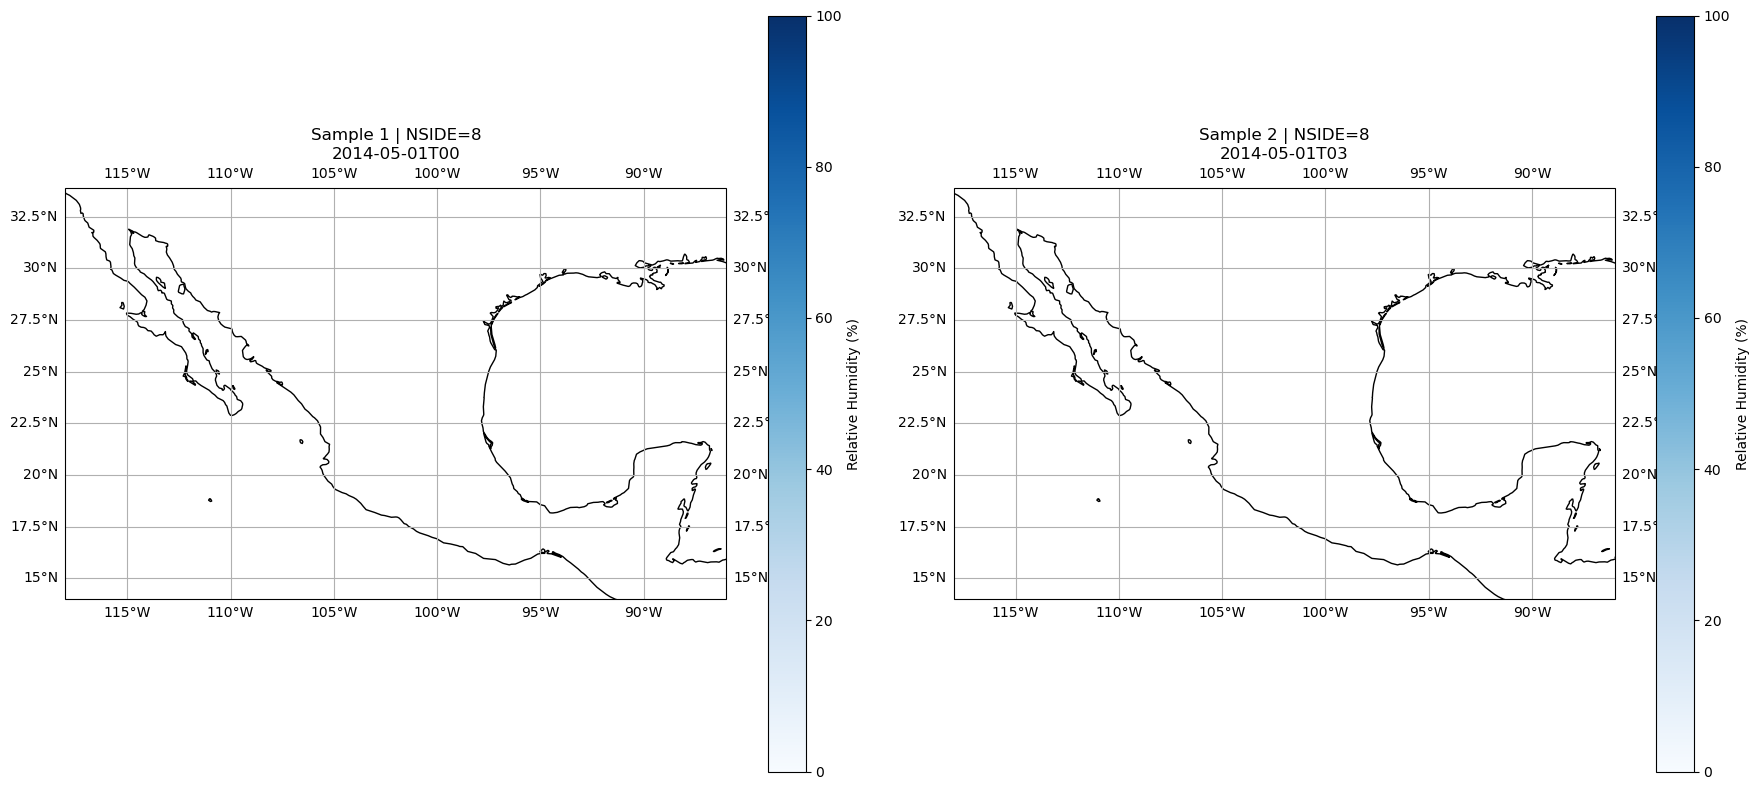

In [12]:
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import healpy as hp
import matplotlib.pyplot as plt

def plot_zarr_samples_cartopy(store_path, nside_group):
    """
    Plot using Cartopy for better regional visualization
    """
    lat_min, lat_max = 14.0, 33.0  
    lon_min, lon_max = -118.0, -86.0
    
    ds_zarr = xr.open_zarr(store_path, consolidated=True)
    nside = int(nside_group.split('_')[1]) if '_' in nside_group else 8
    npix = hp.nside2npix(nside)
    
    # Get pixel coordinates
    pixels = np.arange(npix)
    theta, phi = hp.pix2ang(nside, pixels)
    lats = 90.0 - np.degrees(theta)
    lons = np.degrees(phi)
    
    # Filter to region
    mask = (
        (lats >= lat_min) & (lats <= lat_max) &
        (lons >= lon_min) & (lons <= lon_max)
    )
    
    time_index_1 = 0
    time_index_2 = min(10, len(ds_zarr.time) - 1)
    
    sample_1 = ds_zarr.isel(time=time_index_1)
    sample_2 = ds_zarr.isel(time=time_index_2)
    
    # Get data for region only
    lats_region = lats[mask]
    lons_region = lons[mask]
    data_1_region = sample_1['precipitation'].values[mask]
    data_2_region = sample_2['precipitation'].values[mask]
    
    # Create figure
    fig, axes = plt.subplots(
        1, 2, 
        figsize=(18, 8),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    # Auto-scale
    valid = np.concatenate([data_1_region, data_2_region])
    valid = valid[~np.isnan(valid)]
    if len(valid) > 0:
        vmin = np.percentile(valid, 1)
        vmax = np.percentile(valid, 99)
    else:
        vmin, vmax = 0, 100
    
    # Plot Sample 1
    sc1 = axes[0].scatter(
        lons_region, lats_region, c=data_1_region,
        cmap='Blues', vmin=vmin, vmax=vmax,
        s=100, transform=ccrs.PlateCarree()
    )
    axes[0].coastlines()
    axes[0].gridlines(draw_labels=True)
    axes[0].set_extent([lon_min, lon_max, lat_min, lat_max])
    axes[0].set_title(f"Sample 1 | NSIDE={nside}\n{np.datetime_as_string(sample_1.time.values, unit='h')}")
    plt.colorbar(sc1, ax=axes[0], label='Relative Humidity (%)')
    
    # Plot Sample 2
    sc2 = axes[1].scatter(
        lons_region, lats_region, c=data_2_region,
        cmap='Blues', vmin=vmin, vmax=vmax,
        s=100, transform=ccrs.PlateCarree()
    )
    axes[1].coastlines()
    axes[1].gridlines(draw_labels=True)
    axes[1].set_extent([lon_min, lon_max, lat_min, lat_max])
    axes[1].set_title(f"Sample 2 | NSIDE={nside}\n{np.datetime_as_string(sample_2.time.values, unit='h')}")
    plt.colorbar(sc2, ax=axes[1], label='Relative Humidity (%)')
    
    plt.tight_layout()
    plt.show()

# Usage
plot_zarr_samples_cartopy("ZARR/IMERG_PRECIP_nside8.zarr", "NSIDE_8")

In [13]:
def diagnose_precipitation_data(store_path):
    """Check what's in your precipitation data"""
    ds_zarr = xr.open_zarr(store_path, consolidated=True)
    
    print("=== Dataset Info ===")
    print(f"Time steps: {len(ds_zarr.time)}")
    print(f"Time range: {ds_zarr.time.values[0]} to {ds_zarr.time.values[-1]}")
    print(f"Variables: {list(ds_zarr.data_vars)}")
    
    # Check precipitation values across all times
    precip_all = ds_zarr['precipitation'].values
    
    print("\n=== Precipitation Statistics (all times) ===")
    print(f"Shape: {precip_all.shape}")
    print(f"Min: {np.nanmin(precip_all)}")
    print(f"Max: {np.nanmax(precip_all)}")
    print(f"Mean: {np.nanmean(precip_all)}")
    
    # Check how many timesteps have rain
    has_rain = []
    for t in range(len(ds_zarr.time)):
        data = ds_zarr['precipitation'].isel(time=t).values
        max_precip = np.nanmax(data)
        n_rainy = np.sum(data > 0.1)  # pixels with >0.1 mm/hr
        has_rain.append((t, max_precip, n_rainy))
        if max_precip > 0:
            print(f"Time {t}: max={max_precip:.2f} mm/hr, rainy pixels={n_rainy}")
    
    # Find time with most rain
    if has_rain:
        best_time = max(has_rain, key=lambda x: x[1])
        print(f"\n=== Time with most rain ===")
        print(f"Time index: {best_time[0]}")
        print(f"Max precipitation: {best_time[1]:.2f} mm/hr")
        print(f"Rainy pixels: {best_time[2]}")

# Run diagnosis
diagnose_precipitation_data("ZARR/IMERG_PRECIP_nside8.zarr")

=== Dataset Info ===
Time steps: 192
Time range: 2014-05-01T00:30:00.000000000 to 2014-05-03T00:00:00.000000000
Variables: ['MWprecipitation', 'randomError', 'precipitationQualityIndex', 'MWobservationTime', 'precipitationUncal', 'MWprecipSource', 'IRprecipitation', 'probabilityLiquidPrecipitation', 'precipitation', 'IRinfluence']

=== Precipitation Statistics (all times) ===
Shape: (192, 768)
Min: 0.0
Max: 2.917588233947754
Mean: 0.11443231999874115
Time 0: max=2.55 mm/hr, rainy pixels=190
Time 1: max=2.55 mm/hr, rainy pixels=190
Time 2: max=2.27 mm/hr, rainy pixels=195
Time 3: max=2.27 mm/hr, rainy pixels=195
Time 4: max=2.26 mm/hr, rainy pixels=197
Time 5: max=2.26 mm/hr, rainy pixels=197
Time 6: max=2.10 mm/hr, rainy pixels=197
Time 7: max=2.10 mm/hr, rainy pixels=197
Time 8: max=2.32 mm/hr, rainy pixels=188
Time 9: max=2.32 mm/hr, rainy pixels=188
Time 10: max=2.15 mm/hr, rainy pixels=189
Time 11: max=2.15 mm/hr, rainy pixels=189
Time 12: max=2.15 mm/hr, rainy pixels=190
Time 13: 

Daily accumulated precipitation:
  Min: 0.00 mm
  Max: 130.81 mm
  Mean: 10.99 mm
  Valid pixels in region: 0
  Pixels with rain (>0.1mm): 0


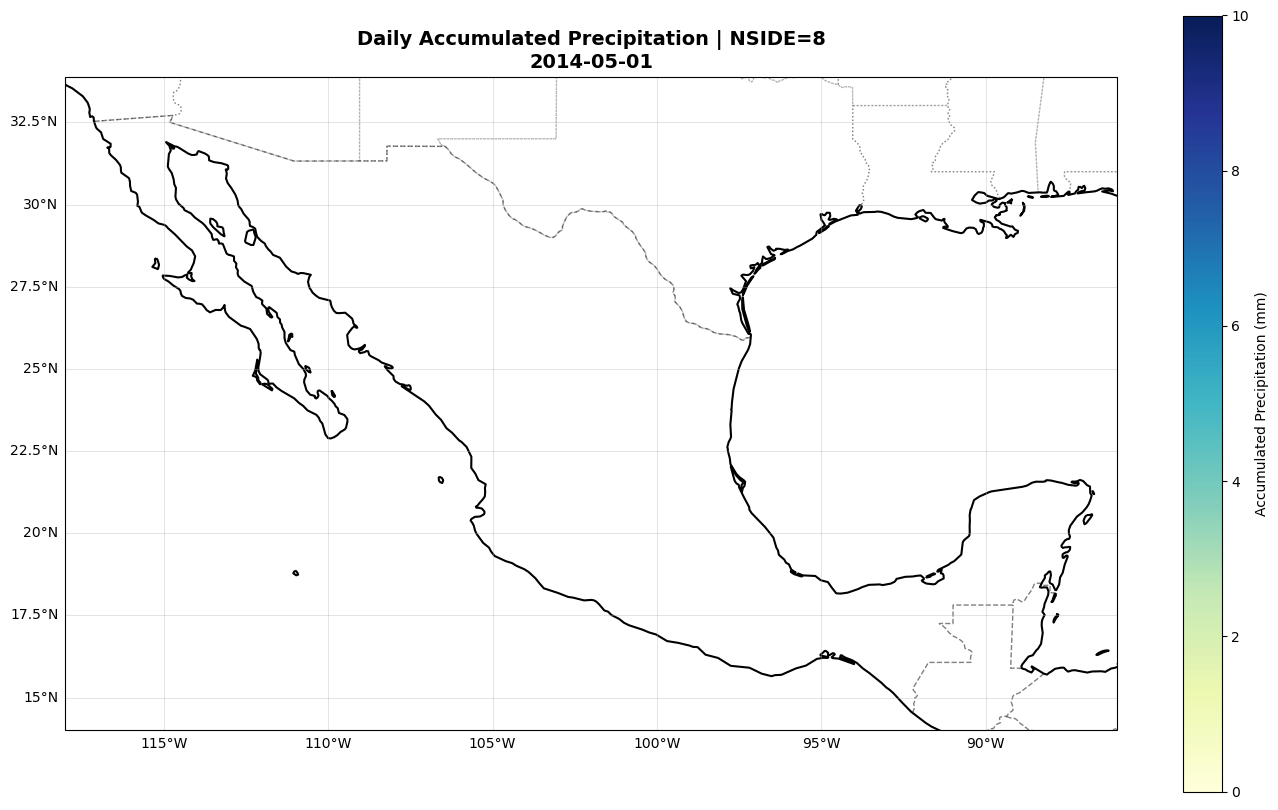

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature  # <- Das fehlt!
import numpy as np
import xarray as xr
import healpy as hp
import matplotlib.pyplot as plt

def plot_daily_accumulated_precipitation(store_path, nside_group):
    """
    Plot accumulated precipitation for the entire day
    """
    lat_min, lat_max = 14.0, 33.0  
    lon_min, lon_max = -118.0, -86.0
    
    ds_zarr = xr.open_zarr(store_path, consolidated=True)
    nside = int(nside_group.split('_')[1]) if '_' in nside_group else 8
    npix = hp.nside2npix(nside)
    
    # Get pixel coordinates
    pixels = np.arange(npix)
    theta, phi = hp.pix2ang(nside, pixels)
    lats = 90.0 - np.degrees(theta)
    lons = np.degrees(phi)
    
    # Filter to region
    mask = (
        (lats >= lat_min) & (lats <= lat_max) &
        (lons >= lon_min) & (lons <= lon_max)
    )
    
    # Calculate daily accumulation
    # IMERG is in mm/hr, multiply by 0.5 (30-min intervals) and sum
    daily_accum = (ds_zarr['precipitation'] * 0.5).sum(dim='time')
    
    print(f"Daily accumulated precipitation:")
    print(f"  Min: {np.nanmin(daily_accum.values):.2f} mm")
    print(f"  Max: {np.nanmax(daily_accum.values):.2f} mm")
    print(f"  Mean: {np.nanmean(daily_accum.values):.2f} mm")
    
    # Get data for region
    lats_region = lats[mask]
    lons_region = lons[mask]
    data_region = daily_accum.values[mask]
    
    # Remove UNSEEN and NaN values
    valid_mask = (data_region != hp.UNSEEN) & (~np.isnan(data_region))
    lats_plot = lats_region[valid_mask]
    lons_plot = lons_region[valid_mask]
    data_plot = data_region[valid_mask]
    
    print(f"  Valid pixels in region: {len(data_plot)}")
    print(f"  Pixels with rain (>0.1mm): {np.sum(data_plot > 0.1)}")
    
    if len(data_plot) > 0 and np.max(data_plot) > 0:
        vmin = 0
        vmax = np.percentile(data_plot[data_plot > 0], 95)
    else:
        vmin, vmax = 0, 10
        print("WARNING: No precipitation detected!")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot
    sc = ax.scatter(
        lons_plot, lats_plot, c=data_plot,
        cmap='YlGnBu', vmin=vmin, vmax=vmax,
        s=200, transform=ccrs.PlateCarree(),
        edgecolors='black', linewidth=0.5
    )
    
    ax.coastlines(linewidth=1.5)
    ax.add_feature(cfeature.BORDERS, linestyle='--', alpha=0.5)  # <- Korrigiert
    ax.add_feature(cfeature.STATES, linestyle=':', alpha=0.3)    # <- Korrigiert
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    
    # Get date from first timestep
    date_str = np.datetime_as_string(ds_zarr.time.values[0], unit='D')
    ax.set_title(f'Daily Accumulated Precipitation | NSIDE={nside}\n{date_str}', 
                 fontsize=14, fontweight='bold')
    
    cbar = plt.colorbar(sc, ax=ax, label='Accumulated Precipitation (mm)', 
                       shrink=0.8, pad=0.05)
    
    plt.tight_layout()
    plt.show()

# Usage
plot_daily_accumulated_precipitation("ZARR/IMERG_PRECIP_nside8.zarr", "NSIDE_8")

In [17]:
def debug_healpix_region(store_path, nside_group):
    """
    Debug why no pixels are found in region
    """
    lat_min, lat_max = 14.0, 33.0  
    lon_min, lon_max = -118.0, -86.0
    
    ds_zarr = xr.open_zarr(store_path, consolidated=True)
    nside = int(nside_group.split('_')[1]) if '_' in nside_group else 8
    npix = hp.nside2npix(nside)
    
    # Get pixel coordinates
    pixels = np.arange(npix)
    theta, phi = hp.pix2ang(nside, pixels)
    lats = 90.0 - np.degrees(theta)
    lons = np.degrees(phi)
    
    print(f"=== HEALPix Grid Info ===")
    print(f"NSIDE: {nside}")
    print(f"Total pixels: {npix}")
    print(f"Lat range: {lats.min():.2f} to {lats.max():.2f}")
    print(f"Lon range: {lons.min():.2f} to {lons.max():.2f}")
    
    # Filter to region
    mask = (
        (lats >= lat_min) & (lats <= lat_max) &
        (lons >= lon_min) & (lons <= lon_max)
    )
    
    print(f"\n=== Region Filter ===")
    print(f"Target region: lat [{lat_min}, {lat_max}], lon [{lon_min}, {lon_max}]")
    print(f"Pixels in region (by coordinates): {np.sum(mask)}")
    
    if np.sum(mask) > 0:
        print(f"Region lat range: {lats[mask].min():.2f} to {lats[mask].max():.2f}")
        print(f"Region lon range: {lons[mask].min():.2f} to {lons[mask].max():.2f}")
    
    # Check the data
    daily_accum = (ds_zarr['precipitation'] * 0.5).sum(dim='time')
    data = daily_accum.values
    
    print(f"\n=== Data Info ===")
    print(f"Data shape: {data.shape}")
    print(f"Data min: {np.nanmin(data):.2f}")
    print(f"Data max: {np.nanmax(data):.2f}")
    print(f"hp.UNSEEN value: {hp.UNSEEN}")
    print(f"Pixels with UNSEEN: {np.sum(data == hp.UNSEEN)}")
    print(f"Pixels with NaN: {np.sum(np.isnan(data))}")
    print(f"Pixels with valid data (not UNSEEN, not NaN): {np.sum((data != hp.UNSEEN) & (~np.isnan(data)))}")
    print(f"Pixels with rain (>0.1mm): {np.sum(data > 0.1)}")
    
    # Check data in region
    if np.sum(mask) > 0:
        data_region = data[mask]
        print(f"\n=== Data in Region ===")
        print(f"Data in region shape: {data_region.shape}")
        print(f"UNSEEN in region: {np.sum(data_region == hp.UNSEEN)}")
        print(f"NaN in region: {np.sum(np.isnan(data_region))}")
        print(f"Valid in region: {np.sum((data_region != hp.UNSEEN) & (~np.isnan(data_region)))}")
        
        # Show first few values
        print(f"First 10 values in region: {data_region[:10]}")

# Run debug
debug_healpix_region("ZARR/IMERG_PRECIP_nside8.zarr", "NSIDE_8")

=== HEALPix Grid Info ===
NSIDE: 8
Total pixels: 768
Lat range: -84.15 to 84.15
Lon range: 0.00 to 354.38

=== Region Filter ===
Target region: lat [14.0, 33.0], lon [-118.0, -86.0]
Pixels in region (by coordinates): 0

=== Data Info ===
Data shape: (768,)
Data min: 0.00
Data max: 130.81
hp.UNSEEN value: -1.6375e+30
Pixels with UNSEEN: 0
Pixels with NaN: 0
Pixels with valid data (not UNSEEN, not NaN): 768
Pixels with rain (>0.1mm): 693


=== Coordinate ranges after conversion ===
Lat range: -84.15 to 84.15
Lon range: -174.38 to 180.00
Pixels in region: 10

Daily accumulated precipitation:
  Min: 0.00 mm
  Max: 130.81 mm
  Mean: 10.99 mm
  Valid pixels in region: 10
  Pixels with rain (>0.1mm): 9
  Color scale: 0.00 to 55.72 mm


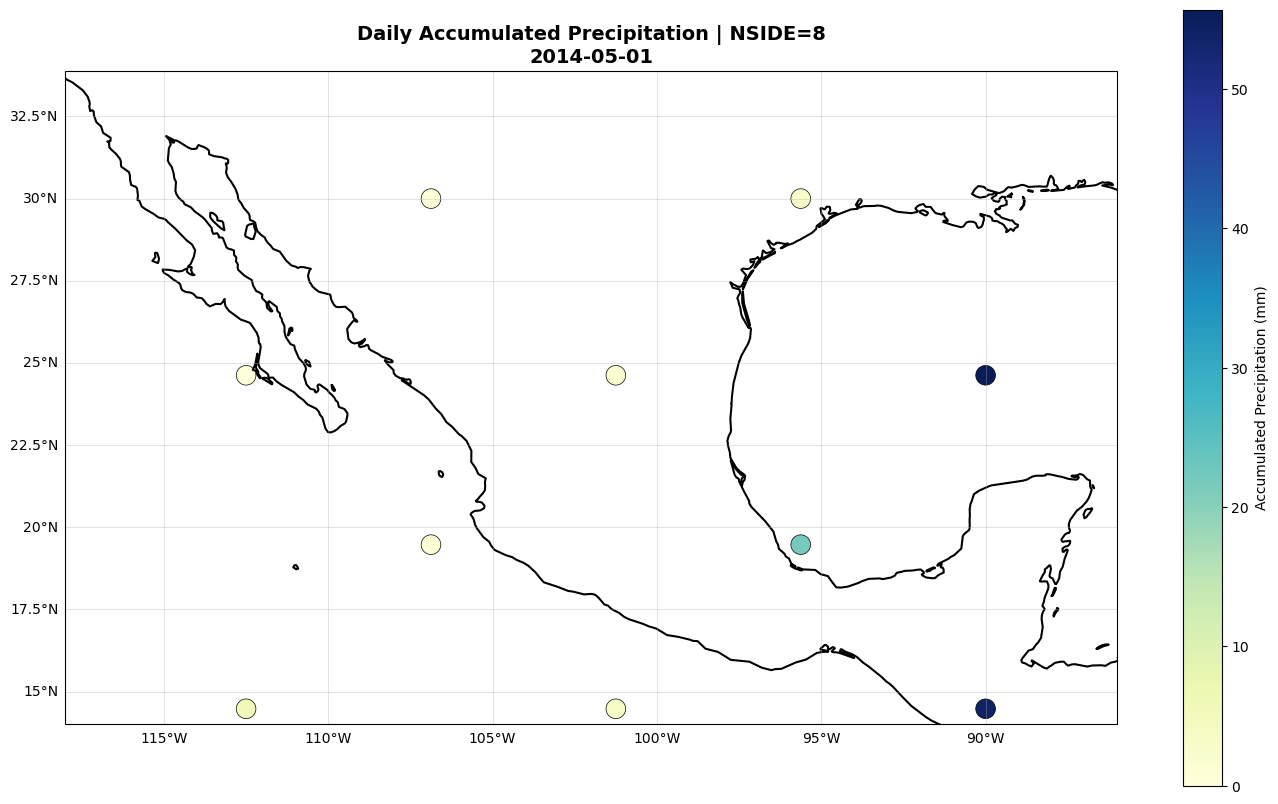

In [18]:
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import healpy as hp
import matplotlib.pyplot as plt

def plot_daily_accumulated_precipitation(store_path, nside_group):
    """
    Plot accumulated precipitation for the entire day
    """
    lat_min, lat_max = 14.0, 33.0  
    lon_min, lon_max = -118.0, -86.0
    
    ds_zarr = xr.open_zarr(store_path, consolidated=True)
    nside = int(nside_group.split('_')[1]) if '_' in nside_group else 8
    npix = hp.nside2npix(nside)
    
    # Get pixel coordinates
    pixels = np.arange(npix)
    theta, phi = hp.pix2ang(nside, pixels)
    lats = 90.0 - np.degrees(theta)
    lons = np.degrees(phi)  # This gives 0-360
    
    # CRITICAL FIX: Convert longitude from 0-360 to -180-180
    lons = np.where(lons > 180, lons - 360, lons)
    
    print(f"=== Coordinate ranges after conversion ===")
    print(f"Lat range: {lats.min():.2f} to {lats.max():.2f}")
    print(f"Lon range: {lons.min():.2f} to {lons.max():.2f}")
    
    # Filter to region (now should work!)
    mask = (
        (lats >= lat_min) & (lats <= lat_max) &
        (lons >= lon_min) & (lons <= lon_max)
    )
    
    print(f"Pixels in region: {np.sum(mask)}")
    
    # Calculate daily accumulation
    # IMERG is in mm/hr, multiply by 0.5 (30-min intervals) and sum
    daily_accum = (ds_zarr['precipitation'] * 0.5).sum(dim='time')
    
    print(f"\nDaily accumulated precipitation:")
    print(f"  Min: {np.nanmin(daily_accum.values):.2f} mm")
    print(f"  Max: {np.nanmax(daily_accum.values):.2f} mm")
    print(f"  Mean: {np.nanmean(daily_accum.values):.2f} mm")
    
    # Get data for region
    lats_region = lats[mask]
    lons_region = lons[mask]
    data_region = daily_accum.values[mask]
    
    # Remove UNSEEN and NaN values
    valid_mask = (data_region != hp.UNSEEN) & (~np.isnan(data_region))
    lats_plot = lats_region[valid_mask]
    lons_plot = lons_region[valid_mask]
    data_plot = data_region[valid_mask]
    
    print(f"  Valid pixels in region: {len(data_plot)}")
    print(f"  Pixels with rain (>0.1mm): {np.sum(data_plot > 0.1)}")
    
    if len(data_plot) > 0 and np.max(data_plot) > 0:
        vmin = 0
        vmax = np.percentile(data_plot[data_plot > 0], 95)
        print(f"  Color scale: {vmin:.2f} to {vmax:.2f} mm")
    else:
        vmin, vmax = 0, 10
        print("WARNING: No precipitation detected!")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot
    sc = ax.scatter(
        lons_plot, lats_plot, c=data_plot,
        cmap='YlGnBu', vmin=vmin, vmax=vmax,
        s=200, transform=ccrs.PlateCarree(),
        edgecolors='black', linewidth=0.5
    )
    
    ax.coastlines(linewidth=1.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    
    # Get date from first timestep
    date_str = np.datetime_as_string(ds_zarr.time.values[0], unit='D')
    ax.set_title(f'Daily Accumulated Precipitation | NSIDE={nside}\n{date_str}', 
                 fontsize=14, fontweight='bold')
    
    cbar = plt.colorbar(sc, ax=ax, label='Accumulated Precipitation (mm)', 
                       shrink=0.8, pad=0.05)
    
    plt.tight_layout()
    plt.show()

# Usage
plot_daily_accumulated_precipitation("ZARR/IMERG_PRECIP_nside8.zarr", "NSIDE_8")